## REMOS segmentation demonstration. 

This Jupyter notebook demonstrates the segmentation applicability of REMOS with 20 minutes data from Bezymianny volcano, recorded on REMOS, on a seismic data stream at Bezymianny volcano recorded on Sunday, 2nd September during the 2007 eruption, station BESA, (Z component)

This demonstration pipeline is purely based on the data preparation and the segmentation part.

![title](img/image_pipeline.png)

First, we will derive an activation vector time using a popular triggering algorithm. After, from the acquired activation vector, we will apply REMOS, visualize the segmentation results and store in Numpy format. 

If using any of the REMOS scripts, please cite the REMOS manuscript on [SRL Journal] (https://pubs.geoscienceworld.org/srl)

Jupyter notebook created by **Angel Bueno (angelbueno@ugr.es)**. Running on the following dependencies:

* Numpy = 1.15.4
* Scipy = 1.2.1
* Obspy = 1.1.0
* Matplotlib = 2.2.3

In [1]:
# First, we import the requested packages.
import remos
import obspy
import os
import numpy as np

# Defining the parameters and deriving the activation vector time (on_off)

As mentioned in the paper, REMOS request an activation vector time to define the exploration regions. In this example, we can use the recursive STA/LTA algorithm to get such vector, along with the number of regions to explore. ALternative methods can be interfaced from the excellent obspy library triggers package [obspy.signal.trigger](https://docs.obspy.org/master/packages/autogen/obspy.signal.trigger.html), or another triggering algorithms, such us [AMPA](https://ieeexplore.ieee.org/abstract/document/6549118). 

REMOS algorithm is built using Python and Obspy libraries and its outputs are consistent with the formats and specifications of Obspy (and as such can also be easily transformed into other formats if required). In essence, if STA/LTA times are incorporated in a coincidence trigger, and windows sizes are defined accordingly for
each station, resulting times could be used for detection/segmentation in a network.


In [2]:
# Once packages are imported, we need to define the parameters that are needed by part of the algorithm. 
delay_in = 4.5

#frequency filters and filtering flag
filtering = True
bandpass = [2.0, 12.0]

#type of trigger (needed for obspy)
trigger_type = "recstalta"
nsta = 3
nlta = 15

#trigger on/off
trig_on = 2.4
trig_of = 1.6

#sampling frequency of the trace.
sampling_frequency = 100.0 

Notice that, in this case, we are reading a ".mseed" file located inside the "data/" folder. On the inners, REMOS work with Numpy Arrays, and we access such array from the Trace.data field defined in Obspy. Please, **make sure the data is in correct format before running REMOS**


In [5]:
readingFolder = os.path.join(os.path.join("data","YC.BESA..HHZ.D.2007.245.mseed"))

In [6]:
original, st, data, cft, on_of = remos.do_sta_lta(readingFolder, nsta, nlta, trig_on, trig_of, filtered=True, bandpass=bandpass)

In [7]:
print on_of[:,1] #array (in samples) of the activation times

[13945 30637 40505 80916 95939]


# SEGMENTATION

Once the on_of times are selected, REMOS consistenly segment the events based on entropy and energy criteria (equation 4 in the paper):

\begin{align}
\text{arg}\,\min\limits_{k}\, E_{k}
\end{align}


This is translated in the function remos_segmentation, which is defined as following:

```python
W_d = 10
W_s = 80
windows = [W_d, W_s]
# Original is the main, unprocessed and unfiltered data, whereas processed is the modified trace. The parameter on is the activation vector, [W_d, W_s] is the windows, epsilon is the threshold, and the other parameters relate to which trace we want to cut, or delay times in case of restrictive triggers. see publication for further details
remos_segmentation(original, processed, on, [W_d, W_s], epsilon=2.5, plot=False, cut="original", delay_in=4.5 )
```

In this example, we will define the hyperparameters needed for the algorithm. W_d or the window size, W_s or the exploration region, both in seconds. **notice that the other hyperparameters are highly dependent of the application in need, and is left to the analyst which ones are best for their analysis** 


In [8]:
window_size = 10.0
search_window = 80.0
duration_windows = [window_size, search_window]    
delay_in = 4.5

In [9]:
#Change to true if you want to see a visualization on the notebook
candidates_segmented = remos.run_remos(original, data, on_of, delay_in, duration_windows, 
                                        epsilon=2.5, plot=False, cut="original")
#we can also clean using the snr threshold
candidates_clean = remos.clean_data(candidates_segmented, snr_thr=30.0, min_duration=10.0)

In [10]:
print candidates_segmented[0] 

[array([-3.4777345 , -2.95105231, -1.77721963, ...,  1.8375833 ,
        1.49711555,  0.72431803]), 0.1, 12450, 17450]


## Examining the outputs. Getting the on_of times for further preprocessing

The output of each segmented candidate follows the same data structure as described in the paper:

![title](img/output_1.png)

Using this matrix, we can extend our analysis and interface with any algorithm we require. 

In [11]:
# We can select the times only. 
positions = np.zeros((len(candidates_segmented), 2))
for k, mem in enumerate(candidates_segmented):
    start = mem[2]
    end = mem[3]
    positions[k] = [start, end]

# VISUALIZATION of RESULTS

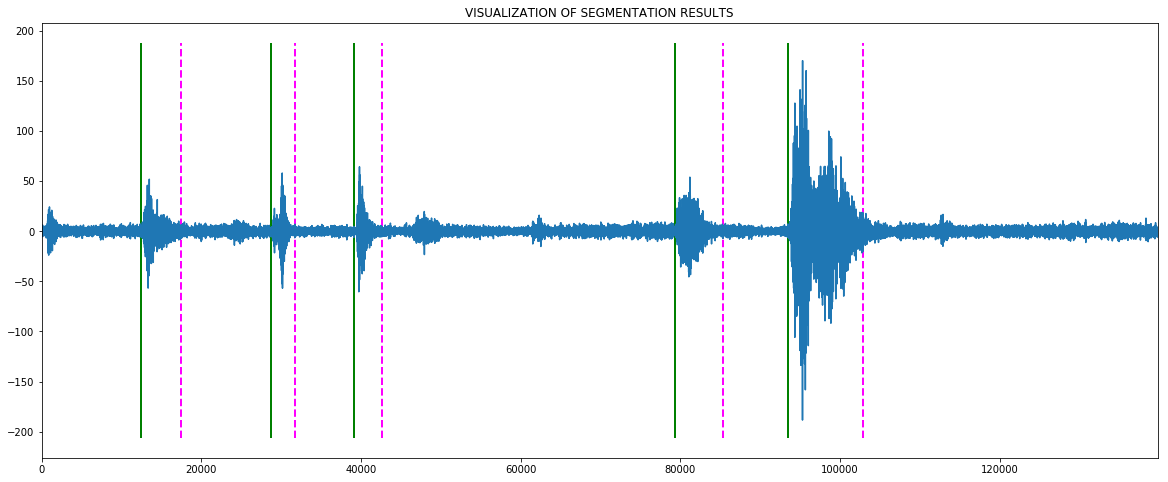

In [12]:
remos.visualize_segmentation(data, positions)

In [13]:
#we can visualize 